# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

Load the run information 

In [2]:
run_info = pd.read_csv('run_data.csv')

Pick one

In [3]:
run_info = run_info.sort_values('start_time', ascending=False).iloc[0]
#run_info = run_info.query('path=="runs/01Aug20-032649-8cadf9"').iloc[0]
print(run_info)

path                                            runs/20Aug20-153807-fc5725
param_hash                                                          fc5725
start_time                                             2020-08-20 15:38:00
mpnn_config_directory                                      ./notebooks/xtb
mpnn_model_files         ['./notebooks/xtb/bootstrap-ensemble/networks/...
initial_agent                    ./notebooks/xtb/moldqn-training/agent.pkl
initial_search_space        ./notebooks/xtb/moldqn-training/best_mols.json
initial_database                     ./notebooks/xtb/initial_database.json
reference_energies                       ./notebooks/xtb/ref_energies.json
qc_spec                                     ./notebooks/xtb/qc_config.json
parallel_guesses                                                        14
rl_episodes                                                             10
search_size                                                           1024
queue_length             

## Load in Result File
This file is the list of the quantum chemistry results

In [4]:
result_data = pd.read_json(os.path.join(run_info['path'], 'simulation_records.jsonld'), lines=True)

Plot the time since first result

In [5]:
result_data['walltime'] = result_data['time_result_received'] - result_data['time_created'].min()

Plot the rate at which we aquired new results

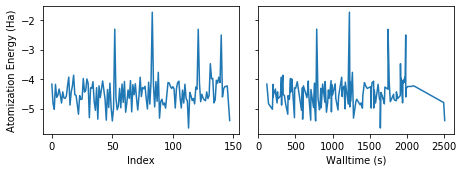

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.5))

axs[0].plot(result_data.index, result_data['value'])
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Atomization Energy (Ha)')

axs[1].plot(result_data['walltime'], result_data['value'])
axs[1].set_xlabel('Walltime (s)')

fig.tight_layout()

## Evaluate Runtimes
Estimate the runtimes of the QC code

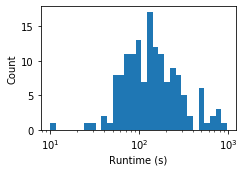

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

wt_range = np.log10([result_data['time_running'].min() * 0.9,
                     result_data['time_running'].max() * 1.1])
ax.hist(result_data['time_running'], bins=np.logspace(*wt_range, 32))
ax.set_xscale('log')

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Count')
fig.tight_layout()

## Evaluate Overhead
Measure the time executing vs the end-to-end time for each of the tasks

In [8]:
rl_data = pd.read_json(os.path.join(run_info['path'], 'generate_records.jsonld'), lines=True)

In [9]:
screen_data = pd.read_json(os.path.join(run_info['path'], 'screen_records.jsonld'), lines=True)

In [10]:
update_data = pd.read_json(os.path.join(run_info['path'], 'update_records.jsonld'), lines=True)

Compute overhead

In [11]:
for data in [result_data, rl_data, screen_data, update_data]:
    data['overhead_time'] = (data['time_result_received'] - data['time_created']) - data['time_running']
    data['overhead_frac'] = 1 - data['time_running'] / (data['time_result_received'] - data['time_created'])

Plot overhead

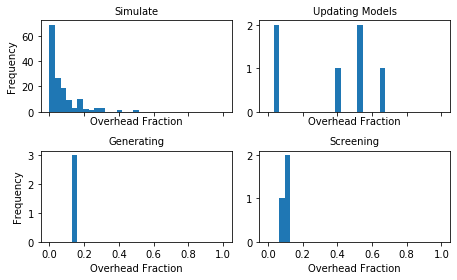

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(6.5, 4.), sharex=True)

for data, label, ax in zip([result_data, update_data, rl_data, screen_data], ['Simulate', 'Updating Models', 'Generating', 'Screening'], axs.flatten()):
    ax.hist(data['overhead_frac'].tolist(), bins=np.linspace(0, 1, 32))
    ax.set_xlabel('Overhead Fraction')
    ax.set_title(f'{label}', fontsize=10)
    
for ax in axs[:, 0]:
    ax.set_ylabel('Frequency')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'overhead-fraction.svg'))

### Explain the overhead
See if we can explain the overhead events for the tasks

Compute each step

In [13]:
for data in [result_data, rl_data, screen_data, update_data]:
    data['client_to_method-server'] = data['time_input_received'] - (data['time_created'] + data['time_serialize_inputs'])
    data['method-server_to_worker'] = data['time_compute_started'] - data['time_input_received']
    data['worker_to_method-server'] = data['time_result_sent'] - (data['time_compute_started']
                                                                  + data['time_running']
                                                                  + data['time_deserialize_inputs']
                                                                  + data['time_serialize_results'])
    data['method-server_to_client'] = data['time_result_received'] - (data['time_result_sent'] + data['time_deserialize_results'])
    data['serialization'] = data[[c for c in data.columns if c.startswith('time_') and 'serialize' in c]].sum(axis=1)

Plot overheads

In [14]:
rl_data[[c for c in data.columns if c.startswith('time_') and 'serialize' in c] + ['worker_to_method-server']]

,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,worker_to_method-server
0,0.489928,9.829177,1.499580,1.763965,3.290743
1,0.368174,9.886484,1.447405,1.487454,3.391838
2,0.360640,9.930004,1.477727,1.422372,3.427684


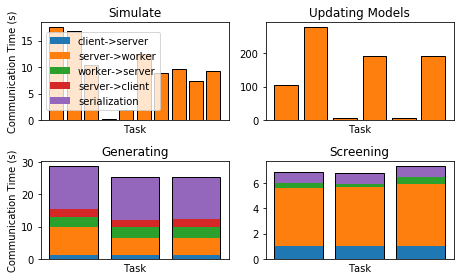

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(6.5, 4.))

for data, label, ax in zip([result_data, update_data, rl_data, screen_data],
                           ['Simulate', 'Updating Models', 'Generating', 'Screening'], 
                           axs.flatten()):
    subset = data.sort_values('time_created', ascending=True).tail(10)
    steps = ['client_to_method-server', 'method-server_to_worker', 'worker_to_method-server', 'method-server_to_client', 'serialization']
    x = np.arange(len(subset))
    for i in range(len(steps)):
        start = subset[steps[:i]].sum(axis=1).values
        ax.bar(x, subset[steps[i]].values, bottom=start, label=steps[i].replace("_to_", "->").replace('method-server', 'server'))
    ax.bar(x, subset['overhead_time'].values, edgecolor='k', facecolor='none', lw=1)
    
    ax.set_xticks([])
    ax.set_title(label)
    ax.set_xlabel('Task')
    
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Communication Time (s)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'overhead-breakdown.svg'))

## Plot the Number of Results Being Run at a Time
We can look at the runtime log to get when QC tasks are sent out and arrive

In [16]:
with open(os.path.join(run_info['path'], 'runtime.log')) as fp:
    log_data = pd.DataFrame(f.rstrip() for f in fp)
log_data.rename(columns={0: 'msg'}, inplace=True)
log_data['msg_num'] = log_data['msg'].str.match(r'^[\d]').cumsum()
log_data = log_data.groupby('msg_num').agg({'msg': lambda x: '\n'.join(x)})

In [17]:
log_data['time'], log_data['parsl'], log_data['level'], log_data['content'] = zip(*log_data['msg'].str.split(" - ", 3))

Compute the time since first message

In [18]:
log_data['time'] = pd.to_datetime(log_data['time'])

In [19]:
log_data['walltime'] = (log_data['time'] - log_data['time'].iloc[0]).apply(lambda x: x.total_seconds())

Find the events related to calculations starting and finishing

In [20]:
events = [{'time': 0, 'active_delta': 0}]
events.extend({'time': t, 'active_delta': -1} for t in 
          log_data[log_data['content'].str.match('^Client received a compute_atomization_energy')]['walltime'])
events.extend([{'time': t, 'active_delta': 1} for t in 
               log_data[log_data['content'].str.match('^Client sent a compute_atomization_energy')]['walltime']])
events = pd.DataFrame(events)

Make the results easier to plot

In [21]:
events.sort_values('time', ascending=True, inplace=True)

In [22]:
events['num_active'] = events['active_delta'].cumsum()

Compute worker utilization

In [23]:
events['queue_length'] = events['num_active']

In [24]:
events['utilization'] = np.clip(events['queue_length'] / run_info['parallel_guesses'], 0, 1)

In [25]:
utilization_int = (np.diff(events['time'].values) * events['utilization'].values[:-1]).cumsum()

In [26]:
events['cumulative_utilization'] = None
events['cumulative_utilization'] = utilization_int / events['time'].iloc[1:]

Plot the queue length and utilization

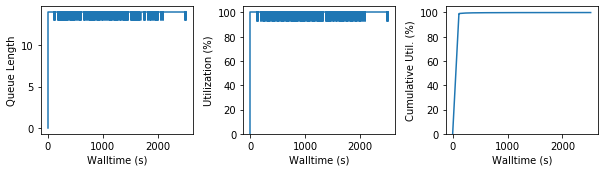

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(8.5, 2.5))

# Plot the queue length
ax = axs[0]
ax.step(events['time'], events['queue_length'], where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Queue Length')

ax = axs[1]
ax.step(events['time'], events['utilization'] * 100, where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Utilization (%)')
ax.set_ylim(0, 105)

ax = axs[2]
ax.plot(events['time'], events['cumulative_utilization'] * 100)
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Cumulative Util. (%)')
ax.set_ylim(0, 105)

fig.tight_layout()